In [ ]:
pip install fasttext

     |████████████████████████████████| 68 kB 4.5 MB/s eta 0:00:011
  Using cached pybind11-2.7.0-py2.py3-none-any.whl (199 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3091199 sha256=31bf7ba8cca3cee956a2d702bf7a79ca265e12d09331a32070c18aed521d4bb0
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
#Downloading libraries
!pip install -U sentence-transformers

     |████████████████████████████████| 85 kB 3.3 MB/s 
     |████████████████████████████████| 2.6 MB 28.3 MB/s 
     |████████████████████████████████| 1.2 MB 60.2 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 895 kB 59.2 MB/s 
     |████████████████████████████████| 636 kB 55.3 MB/s 
     |████████████████████████████████| 3.3 MB 59.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-py3-none-any.whl size=126709 sha256=80455cc5b083fb873e45377cbf71c88fec349743fd41bc828ea26f8f94e13d56
  Stored in directory: /root/.cache/pip/wheels/d1/c1/0f/faafd427f705c4b012274ba60d9a91d75830306811e1355293
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [ ]:
cv  = pd.read_csv('drive/My Drive/Thesis/Data/cov_data_may.csv')
cv_case = cv[['Date','New Cases']]
cv_case

,Date,New Cases
0,2021-05-01 00:00:00+00:00,4512
1,2021-05-02 00:00:00+00:00,4394
2,2021-05-03 00:00:00+00:00,4730
3,2021-05-04 00:00:00+00:00,4369
4,2021-05-05 00:00:00+00:00,5285
5,2021-05-06 00:00:00+00:00,5647
6,2021-05-07 00:00:00+00:00,6327
7,2021-05-08 00:00:00+00:00,6130
8,2021-05-09 00:00:00+00:00,3922
9,2021-05-10 00:00:00+00:00,4891


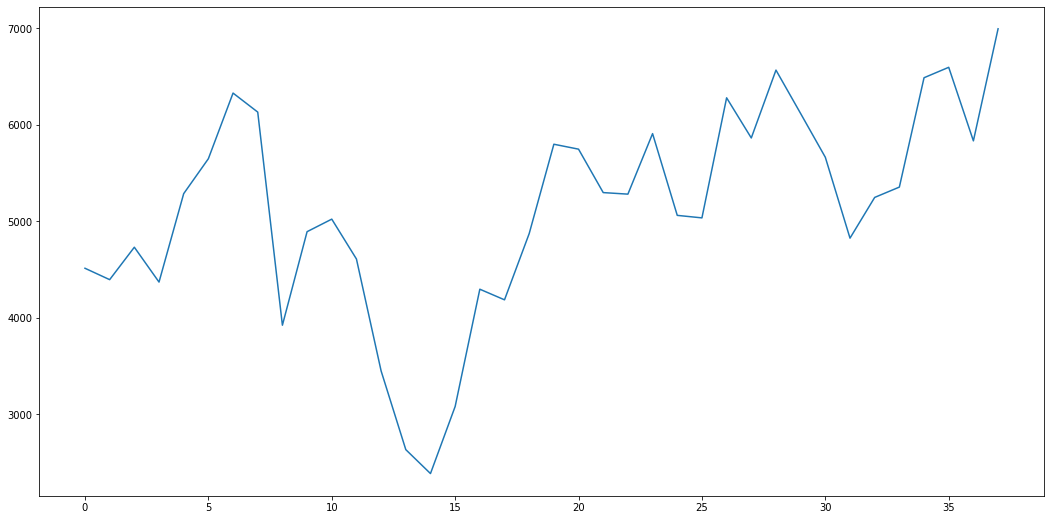

In [ ]:
new_cases = cv_case[['New Cases']]
plt.subplots(figsize=(18, 9))
plt.plot(new_cases)
plt.show()

Prediction using covid new case

7 days 

In [ ]:
covid_data = new_cases.values.astype(float)

train_data = covid_data[:31]
test_data = covid_data[31:]

print(len(train_data))
print(len(test_data))

31
7


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_window = 7

def create_inout_sequences(input_data, tw):
  inout_seq = []
  L = len(input_data)
  for i in range(L-tw):
    train_seq = input_data[i:i+tw]
    train_label = input_data[i+tw:i+tw+1]
    inout_seq.append((train_seq, train_label))
  return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [ ]:
#Model
class LSTM(nn.Module):
  def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
    super().__init__()
    self.hidden_layer_size = hidden_layer_size
    self.lstm = nn.LSTM(input_size, hidden_layer_size)
    self.linear = nn.Linear(hidden_layer_size, output_size)
    self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                        torch.zeros(1,1,self.hidden_layer_size))
    
  def forward(self, input_seq):
    lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
    predictions = self.linear(lstm_out.view(len(input_seq), -1))
    return predictions[-1]

model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#Training
epochs = 1000

for i in range(epochs):
  for seq, labels in train_inout_seq:
    optimizer.zero_grad()
    model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                         torch.zeros(1, 1, model.hidden_layer_size))
    
    y_pred = model(seq)

    single_loss = loss_function(y_pred, labels)
    single_loss.backward()
    optimizer.step()

  if i%100==1:
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


epoch:   1 loss: 0.00015547
epoch: 101 loss: 0.00003242
epoch: 201 loss: 0.00001228
epoch: 301 loss: 0.00000005
epoch: 401 loss: 0.00000000
epoch: 501 loss: 0.00000585
epoch: 601 loss: 0.00000003
epoch: 701 loss: 0.00002976
epoch: 801 loss: 0.00005389
epoch: 901 loss: 0.00003985
epoch: 999 loss: 0.0000001087


In [ ]:
#Prediction
fut_pred = 7

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

model.eval()

for i in range(fut_pred):
  seq = torch.FloatTensor(test_inputs[-train_window:])
  with torch.no_grad():
    model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                    torch.zeros(1, 1, model.hidden_layer_size))
    test_inputs.append(model(seq).item())

test_inputs[fut_pred:]
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)



[0.279904305934906, 0.2674641013145447, 0.8626794219017029, 0.6636363863945007, 1.0, 0.7846890091896057, 0.5679425597190857]
[[6084.8914361 ]
 [6012.53915131]
 [5703.39442253]
 [6033.44884813]
 [6196.59767628]
 [6030.06629825]
 [5903.137151  ]]


In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def mse(predict,target):
    return ((predict-target)**2).mean()

def mae(predict,target):
    return (abs(predict-target)).mean()

def mape(predict,target):
    return ( abs((target - predict) / target).mean()) * 100

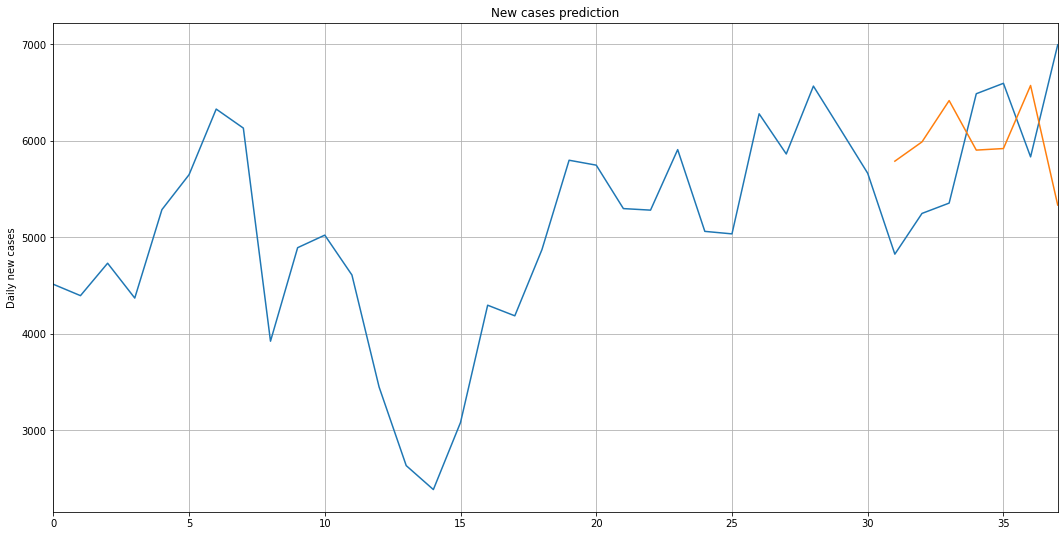

In [ ]:
#plotting prediction
model = 'lstm'
dr = 'drive/My Drive/Thesis/Data/images/task2_7721_1/'
x = np.arange(31, 38, 1)
plt.subplots(figsize=(18, 9))
plt.title('New cases prediction')
plt.ylabel('Daily new cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(covid_data)
plt.plot(x,actual_predictions)
plt.savefig(dr + model + '_prediction')   
plt.show()

In [ ]:
#Pred LSTM 1
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions))
print('MAPE : ', mape (cov[-7:], actual_predictions))
print('MSE : ', mse( cov[-7:], actual_predictions))
print('RMSE : ', rmse( cov[-7:], actual_predictions))

MAE :  New Cases    918.035784
dtype: float64
MAPE :  New Cases    15.612045
dtype: float64
MSE :  New Cases    958113.993668
dtype: float64
RMSE :  New Cases    978.832975
dtype: float64


In [ ]:
#Pred LSTM 2
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions))
print('MAPE : ', mape (cov[-7:], actual_predictions))
print('MSE : ', mse( cov[-7:], actual_predictions))
print('RMSE : ', rmse( cov[-7:], actual_predictions))

MAE :  New Cases    675.011505
dtype: float64
MAPE :  New Cases    11.323394
dtype: float64
MSE :  New Cases    572730.088285
dtype: float64
RMSE :  New Cases    756.789329
dtype: float64


In [ ]:
#Pred LSTM 3
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions))
print('MAPE : ', mape (cov[-7:], actual_predictions))
print('MSE : ', mse( cov[-7:], actual_predictions))
print('RMSE : ', rmse( cov[-7:], actual_predictions))

MAE :  New Cases    709.736913
dtype: float64
MAPE :  New Cases    12.277889
dtype: float64
MSE :  New Cases    622234.86448
dtype: float64
RMSE :  New Cases    788.818651
dtype: float64


In [ ]:
#Pred LSTM 4
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions))
print('MAPE : ', mape (cov[-7:], actual_predictions))
print('MSE : ', mse( cov[-7:], actual_predictions))
print('RMSE : ', rmse( cov[-7:], actual_predictions))

MAE :  New Cases    645.10109
dtype: float64
MAPE :  New Cases    10.753616
dtype: float64
MSE :  New Cases    555709.739364
dtype: float64
RMSE :  New Cases    745.459415
dtype: float64


In [ ]:
#Pred LSTM 5
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions))
print('MAPE : ', mape (cov[-7:], actual_predictions))
print('MSE : ', mse( cov[-7:], actual_predictions))
print('RMSE : ', rmse( cov[-7:], actual_predictions))

MAE :  New Cases    1103.19372
dtype: float64
MAPE :  New Cases    23.258139
dtype: float64
MSE :  New Cases    1.933084e+06
dtype: float64
RMSE :  New Cases    1390.354088
dtype: float64


Prediction using covid new cases and tweets

7 days

In [ ]:
#Importing dependencies
import gensim
from gensim.models import KeyedVectors
from gensim import corpora
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
from gensim.models.coherencemodel import CoherenceModel
import os
from sentence_transformers import SentenceTransformer
import copy
from datetime import datetime
import warnings
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import contextlib
import spacy
import re
import random
import math
from gensim.utils import simple_preprocess
import fasttext.util


#word2vec, glove, fasttext
class WordVecVectorizer(object):
    def __init__(self, model, method):
        self.model = model
        self.method = method

        if method == 'WORD2VEC':
          self.dim = 100 
                     
        elif method == 'GLOVE':
           self.dim = 5 
           
        elif method == 'FASTTEXT':           
            self.dim = 300
        else:
          self.dim = 200
       
        
    def fit(self, X, y):
        return self    
        
    def transform(self, X):
        return np.array([
            np.mean([self.model[w] for w in texts.split() if w in self.model]
                    or [np.zeros(self.dim)], axis=0)
            for texts in X              
        ])

In [ ]:
def plotting(pred, mod, ds):
  dr = 'drive/My Drive/Thesis/Data/images/task2_7721_1/'
  x = np.arange(31, 38, 1)
  plt.subplots(figsize=(18, 9))
  plt.title('New cases prediction')
  plt.ylabel('Daily new cases')
  plt.grid(True)
  plt.autoscale(axis='x', tight=True)
  plt.plot(new_cases)
  plt.plot(x,pred)
  plt.savefig(dr + mod + '_prediction_' + ds)   
  plt.show()


def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def mse(predict,target):
    return ((predict-target)**2).mean()

def mae(predict,target):
    return (abs(predict-target)).mean()

def mape(predict,target):
    return ( abs((target - predict) / target).mean()) * 100




In [ ]:
def create_inout_sequences(input_data, tw):
  inout_seq = []
  L = len(input_data)
  for i in range(L-tw):
    train_seq = input_data[i:i+tw]
    train_label = input_data[i+tw:i+tw+1]
    inout_seq.append((train_seq, train_label))
  return inout_seq


In [ ]:
#Model
class LSTM(nn.Module):
  def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
    super().__init__()
    self.hidden_layer_size = hidden_layer_size
    self.lstm = nn.LSTM(input_size, hidden_layer_size)
    self.linear = nn.Linear(hidden_layer_size, output_size)
    self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                        torch.zeros(1,1,self.hidden_layer_size))
    
  def forward(self, input_seq):
    lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
    predictions = self.linear(lstm_out.view(len(input_seq), -1))
    return predictions[-1]

In [ ]:
def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel



def vectorize(method, sentences):
  if method == 'BOW':
    print('Getting vector representations for BoW ...')
    dictionary = corpora.Dictionary()
    doc_tokenized = [simple_preprocess(doc) for doc in sentences]
    BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]
    vec = np.array(BoW_corpus)
    print('Getting vector representations for BoW. Done!')
    return vec

  elif method == 'BERT':
    print('Getting vector representations for BERT ...')
    model = SentenceTransformer('indobenchmark/indobert-base-p1')
    vec = np.array(model.encode(sentences, show_progress_bar=True))
    print('Getting vector representations for BERT. Done!')
    return vec

  elif method == 'WORD2VEC':
     print('Getting vector representations for WORD2VEC ...')
     model = gensim.models.KeyedVectors.load_word2vec_format('drive/My Drive/Thesis/pretrained_model/word2vec/model.bin', binary=True) 
     wtv_vect = WordVecVectorizer(model, method)
     embeddings = wtv_vect.transform(sentences)
     vec = np.vstack(embeddings)
     print('Getting vector representations for WORD2VEC. Done!')
     return vec

  elif method == 'GLOVE':
    print('Getting vector representations for GLOVE ...')
    model = loadGloveModel("drive/My Drive/Thesis/Data/gensim_glove_vectors.txt") 
    wtv_vect = WordVecVectorizer(model, method)
    embeddings = wtv_vect.transform(sentences)
    vec = np.vstack(embeddings)
    print('Getting vector representations for GLOVE. Done!')
    return vec

  elif method == 'FASTTEXT':
    print('Getting vector representations for FASTTEXT ...')
    #loading the model
    model = fasttext.load_model('drive/My Drive/Thesis/pretrained_model/fasttext/model.bin') 
    wtv_vect = WordVecVectorizer(model, method)
    embeddings = wtv_vect.transform(sentences)
    vec = np.vstack(embeddings)
    print('Getting vector representations for FASTTEXT. Done!')
    return vec       
        
        
  
            

       

In [ ]:
#loading covid data 
cv  = pd.read_csv('drive/My Drive/Thesis/Data/cov_data_may.csv')
new_cases = cv['New Cases']
cv_feature = new_cases[:31]



In [ ]:
#loading tweet data
tw  = pd.read_csv('drive/My Drive/Thesis/Data/Tweet_TM/task1_may_june/bert_cluster_3_combined.csv')
tw_feature = tw['clean_sentences']


In [ ]:
#create vector for tweets
method = 'BERT'
tweet_feature  = vectorize(method, tw_feature)



Getting vector representations for BERT ...



Getting vector representations for BERT. Done!


Concatination - Bag of word

In [ ]:
#Bow
from torch.nn.utils.rnn import pad_sequence
t = pad_sequence([torch.tensor(x) for x in tweet_feature], batch_first=True)

t.shape

torch.Size([31, 964, 2])

In [ ]:
#concatenating features Bow
x1 = torch.Tensor(cv_feature)
x2 = pad_sequence([torch.tensor(x) for x in tweet_feature], batch_first=True)
x2 = x2.view(31,1928)
x1 = x1.view(31, 1) 
x = torch.cat((x1, x2),1)

x = x.detach().numpy()
train_data = np.array([])
for x in x:
  train_data = np.append(train_data, x[0])
train_data.shape

(31,)

Concatination - Text Embeddings (Word2vec, Glove, FastText, BERT)

In [ ]:
tweet_feature.shape

(31, 768)

In [ ]:
#concatenating features

features = nn.Sequential(
            nn.Linear(768, 1),
            nn.ReLU(),
        )

x1 = torch.Tensor(cv_feature)
x2 = features(torch.Tensor(tweet_feature))
x1 = x1.view(31, 1) 
x = torch.cat((x1, x2),1)

x = x.detach().numpy()
train_data = np.array([])
for x in x:
  train_data = np.append(train_data, x[0])
train_data.shape

(31,)

Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_window = 7

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)



In [ ]:
#MODEL
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Training
epochs = 1000

for i in range(epochs):
  for seq, labels in train_inout_seq:
    optimizer.zero_grad()
    model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                         torch.zeros(1, 1, model.hidden_layer_size))
    
    y_pred = model(seq)

    single_loss = loss_function(y_pred, labels)
    single_loss.backward()
    optimizer.step()

  if i%100==1:
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


epoch:   1 loss: 0.12620191
epoch: 101 loss: 0.00030162
epoch: 201 loss: 0.00005512
epoch: 301 loss: 0.00123680
epoch: 401 loss: 0.00105514
epoch: 501 loss: 0.00506565
epoch: 601 loss: 0.00033109
epoch: 701 loss: 0.00091963
epoch: 801 loss: 0.00163923
epoch: 901 loss: 0.00003015
epoch: 999 loss: 0.0000000732


In [ ]:
#Prediction
test_data = new_cases[31:]
fut_pred = 7

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

model.eval()

for i in range(fut_pred):
  seq = torch.FloatTensor(test_inputs[-train_window:])
  with torch.no_grad():
    model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                    torch.zeros(1, 1, model.hidden_layer_size))
    test_inputs.append(model(seq).item())

test_inputs[fut_pred:]
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)


[0.279904305934906, 0.2674641013145447, 0.8626794219017029, 0.6636363863945007, 1.0, 0.7846890091896057, 0.5679425597190857]
[[5835.50459027]
 [5793.76616955]
 [5916.81646526]
 [6341.16185129]
 [6128.37613106]
 [5921.97892427]
 [5940.90889573]]


Bow Topic 0

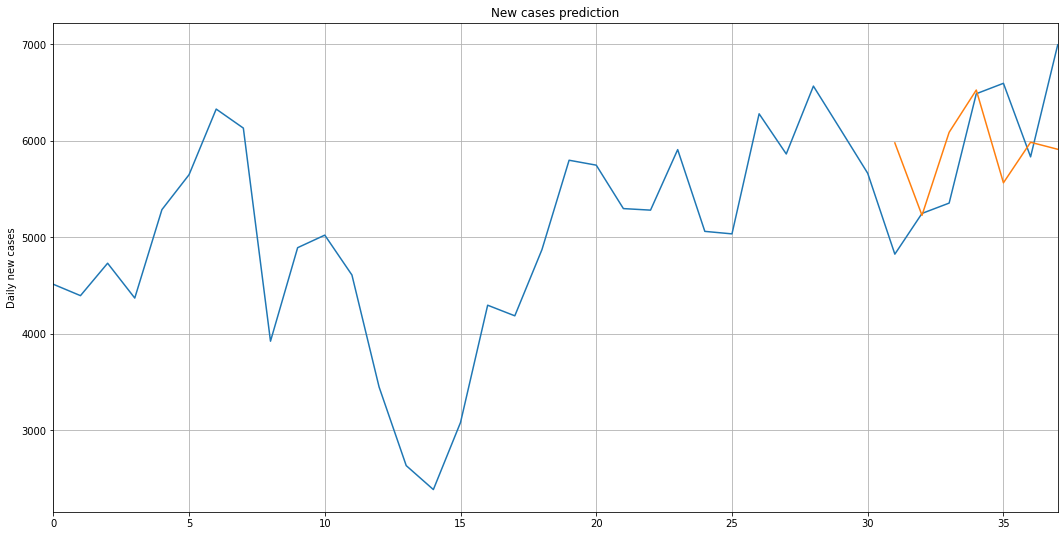

In [ ]:
#plotting prediction 
model = 'BOW'
dataset = '0'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  601.2144197566168
MAPE :  10.238644901172966
MSE :  589331.0839147118
RMSE :  767.6790240163605


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  836.3717745712826
MAPE :  13.725607210835221
MSE :  931949.4021664446
RMSE :  965.3752649443866


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  606.3776737281254
MAPE :  10.116128308108253
MSE :  483073.19289288326
RMSE :  695.0346702811905


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  632.16816840853
MAPE :  10.512475657588407
MSE :  519142.2303262285
RMSE :  720.5152533612516


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  575.5207129716873
MAPE :  9.795827965713652
MSE :  467238.41518114874
RMSE :  683.5484000282268


Bow Topic 1

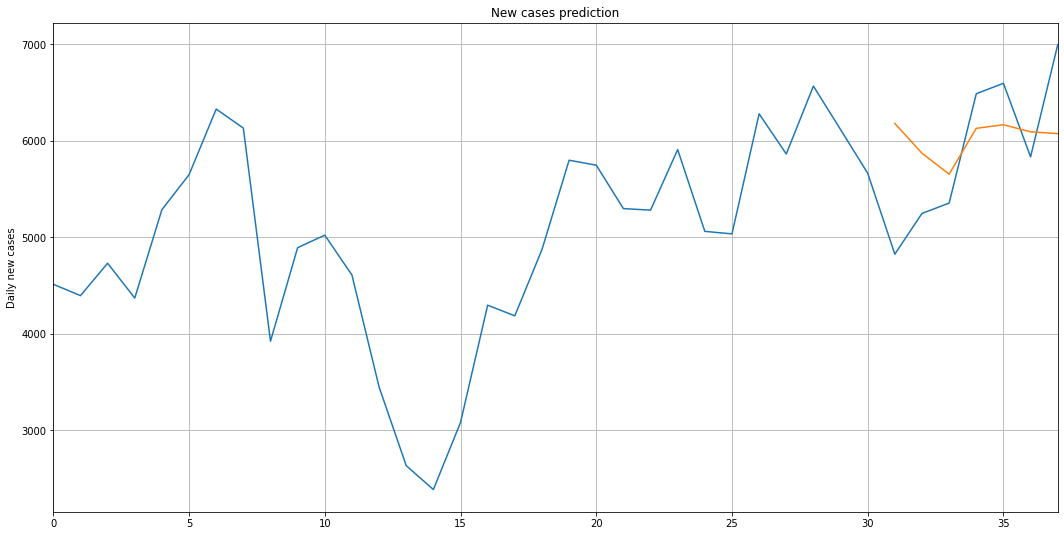

In [ ]:
#plotting prediction
model = 'BOW'
dataset = '1'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  606.3775669506618
MAPE :  10.009695867845538
MSE :  505516.37852101366
RMSE :  710.9967500073496


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  698.2123893073627
MAPE :  11.916184474641476
MSE :  624159.7451601595
RMSE :  790.0378124875793


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  602.0288130726133
MAPE :  10.161650247878153
MSE :  525478.7754233598
RMSE :  724.899148449879


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  563.7247040271759
MAPE :  9.519239614636207
MSE :  429590.407149399
RMSE :  655.431466401636


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  569.0631145068577
MAPE :  9.70983768782002
MSE :  456979.7548836716
RMSE :  676.0027772751171


Bow Topic 2

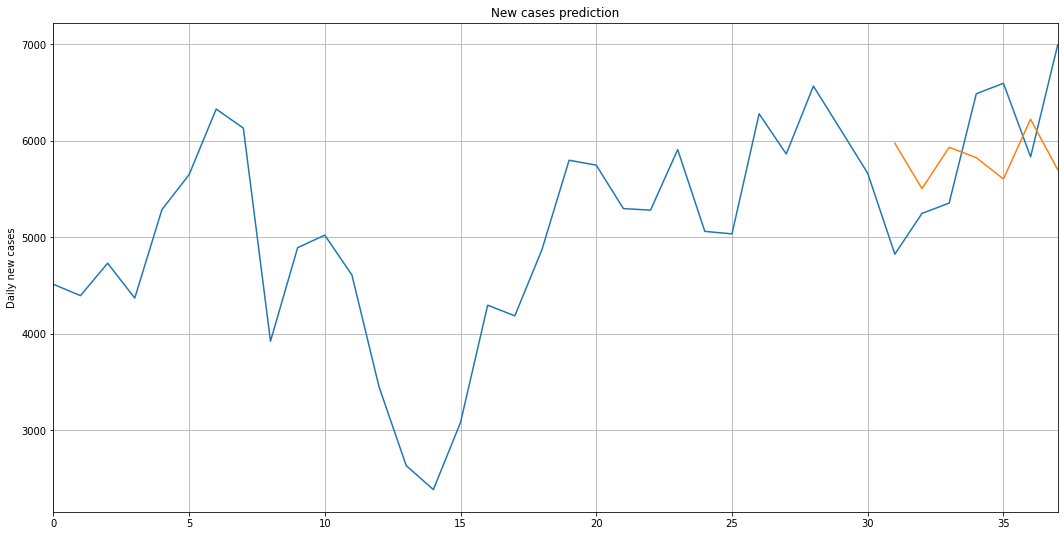

In [ ]:
#plotting prediction
model = 'BOW'
dataset = '2'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  760.0181378040995
MAPE :  13.095860513318087
MSE :  709492.9958403131
RMSE :  842.314071970968


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  595.6192600471633
MAPE :  10.691229378027245
MSE :  571139.5920049085
RMSE :  755.7377799242992


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  492.2163779905864
MAPE :  8.343248537279853
MSE :  365716.1716928957
RMSE :  604.744716134747


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  1387.4822170819555
MAPE :  34.399478635605334
MSE :  3234268.6148234555
RMSE :  1798.4072438753842


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  578.6048198427472
MAPE :  9.752172731327436
MSE :  462438.7219576182
RMSE :  680.0284714316145


Bow Topic 3

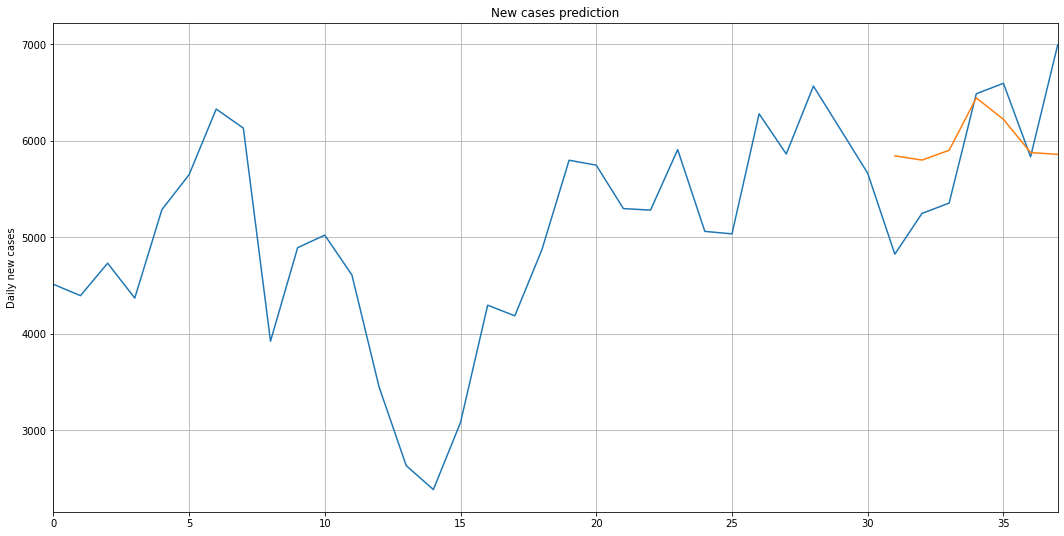

In [ ]:
#plotting prediction
model = 'BOW'
dataset = '3'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  530.5233550752912
MAPE :  9.004280394042226
MSE :  439020.9071591261
RMSE :  662.5865280543561


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  559.7274023294449
MAPE :  9.506891548027523
MSE :  488803.9027130911
RMSE :  699.1451227843123


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  632.2140012128012
MAPE :  10.323153715211198
MSE :  526977.1301927156
RMSE :  725.931904652713


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  573.3934389523098
MAPE :  9.69323401675208
MSE :  451991.5794908102
RMSE :  672.3031901536763


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  577.9851354105132
MAPE :  9.981978552341744
MSE :  493926.56363875157
RMSE :  702.7990919450249


Word2vec Topic 0

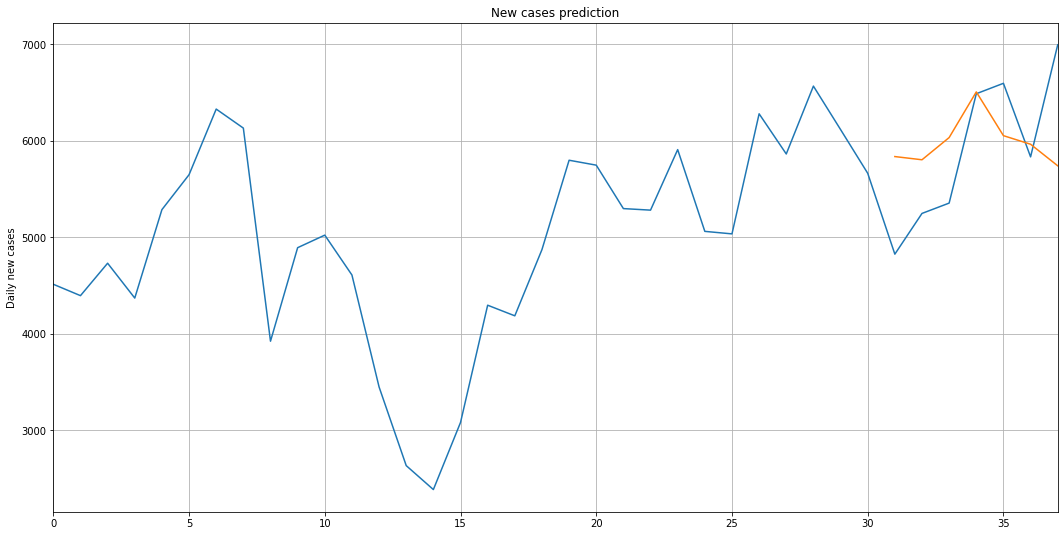

In [ ]:
#plotting prediction
model = 'word2vec'
dataset = '0'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  598.7961431571415
MAPE :  10.207592781577226
MSE :  525029.5291245905
RMSE :  724.589214054826


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  653.2684749535152
MAPE :  10.842916060708752
MSE :  588151.0904323197
RMSE :  766.9100927959677


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  545.3550191947392
MAPE :  9.33644227448751
MSE :  480925.389605267
RMSE :  693.4878438770697


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  509.3960813794817
MAPE :  8.49517554983081
MSE :  420309.4788200493
RMSE :  648.3127939660371


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  584.33560190882
MAPE :  9.825613173137882
MSE :  513390.43297305994
RMSE :  716.5126886336766


Word2vec Topic 1

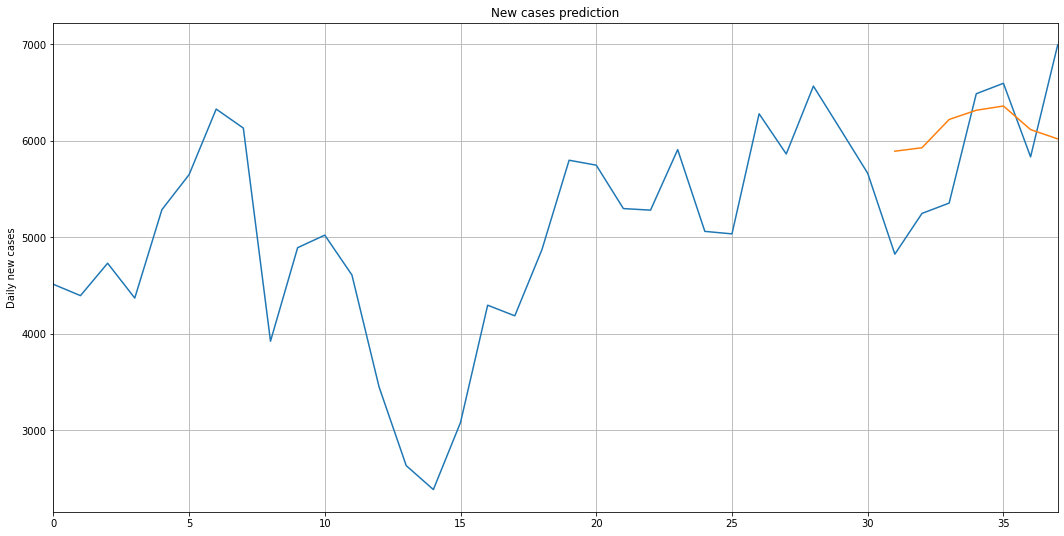

In [ ]:
#plotting prediction
model = 'word2vec'
dataset = '1'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  611.0515724590847
MAPE :  10.107239850644607
MSE :  495178.84458111227
RMSE :  703.6894518046382


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  615.940770149231
MAPE :  10.399492932863055
MSE :  545276.3597298886
RMSE :  738.4283037166767


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  581.287108378751
MAPE :  10.026741844285105
MSE :  512427.2853240279
RMSE :  715.8402652296306


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  617.7619131803513
MAPE :  10.326790910374903
MSE :  505698.5800109038
RMSE :  711.1248694926256


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  551.1979813064847
MAPE :  9.393369245830966
MSE :  444673.7097845772
RMSE :  666.8385935026386


Word2vec Topic 2

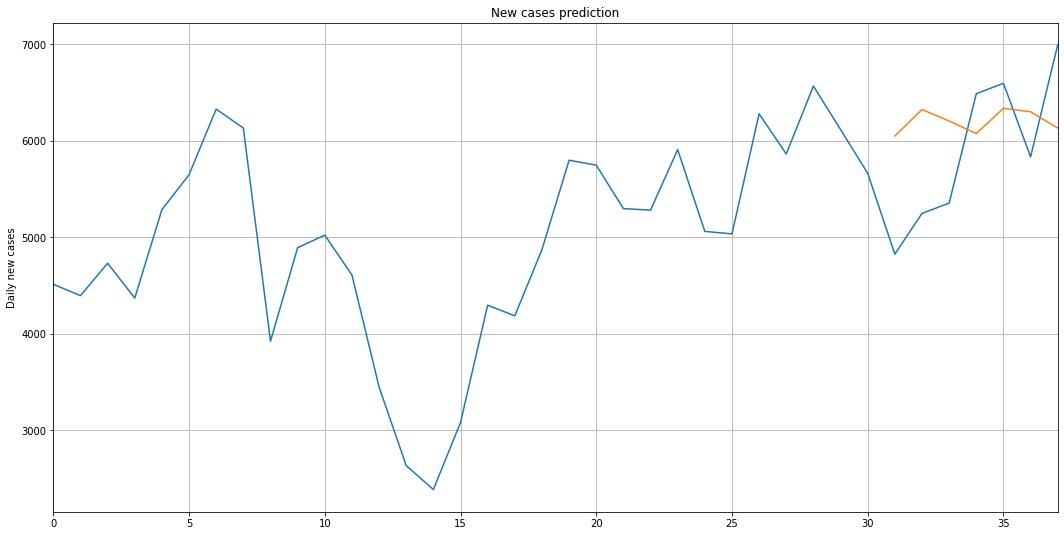

In [ ]:
#plotting prediction
model = 'word2vec'
dataset = '2'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  578.7767493554524
MAPE :  9.844360239177565
MSE :  509719.03229674755
RMSE :  713.9460990136073


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  493.93297840867723
MAPE :  8.480953511971535
MSE :  361615.05504983565
RMSE :  601.3443730923535


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  1245.8671021461487
MAPE :  28.436317005582364
MSE :  2532318.1012800997
RMSE :  1591.3258941147471


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  514.2851027420589
MAPE :  9.006988378105493
MSE :  472346.0446326012
RMSE :  687.2743590681972


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  580.6329509871347
MAPE :  9.838508335665704
MSE :  446456.8323168914
RMSE :  668.174252958681


Word2vec Topic 3

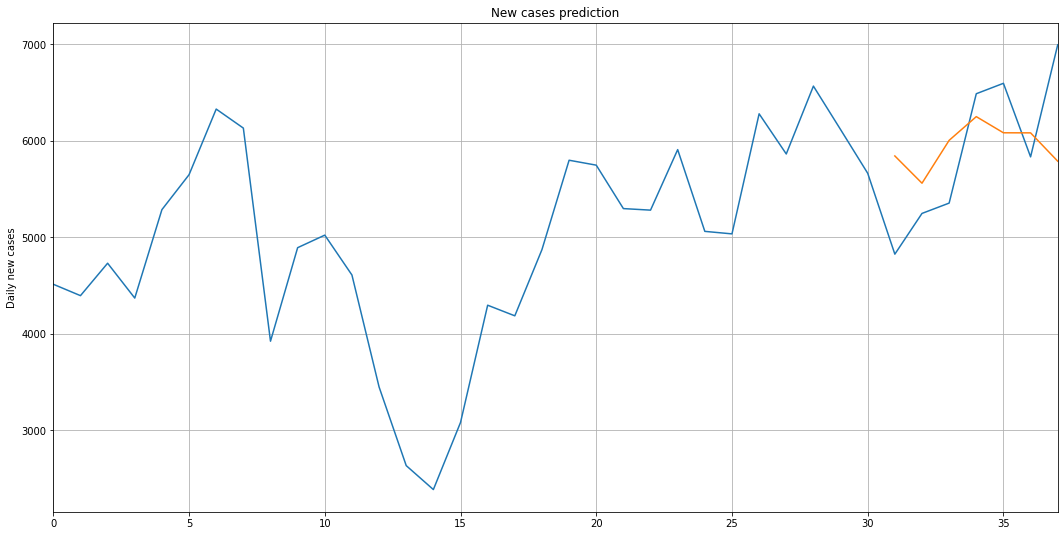

In [ ]:
#plotting prediction
model = 'word2vec'
dataset = '3'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  597.854660987854
MAPE :  10.147317098649554
MSE :  484416.30637796415
RMSE :  696.0002200990774


In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  567.9015536648886
MAPE :  9.587222308120426
MSE :  486734.1980493501
RMSE :  697.663384483771


In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  638.3465156895774
MAPE :  10.757230168182561
MSE :  559879.498092669
RMSE :  748.2509592995314


In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  482.5957463128226
MAPE :  8.330547108358298
MSE :  395464.7462924034
RMSE :  628.8598781067237


In [ ]:
cov = new_cases[:38]

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  539.0590743337359
MAPE :  8.836855136474309
MSE :  456004.58560465235
RMSE :  675.2811159840414


Glove Topic 0

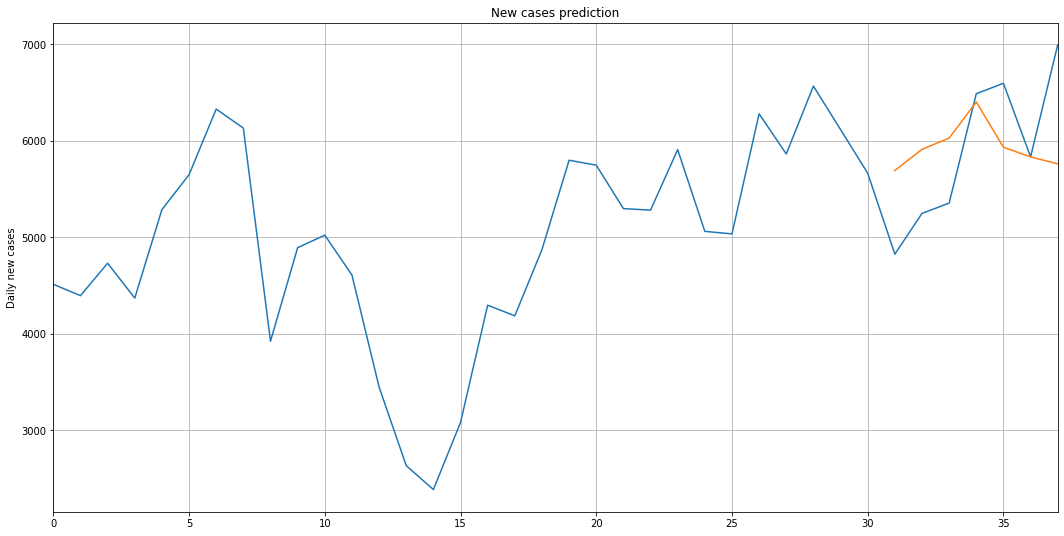

In [ ]:
#plotting prediction
model = 'glove'
dataset = '0'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  597.8960492100034
MAPE :  10.221957310355856
MSE :  515923.18921595387
RMSE :  718.277933126136


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  594.7395708560944
MAPE :  9.989746629974947
MSE :  476508.66235282586
RMSE :  690.2960686204332


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  539.7441304240908
MAPE :  9.122736203146587
MSE :  450408.83298352826
RMSE :  671.1250501832935


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  589.3070538384574
MAPE :  9.912199470812325
MSE :  459476.43644171517
RMSE :  677.8469122462056


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  592.6165145465305
MAPE :  9.998113232216998
MSE :  480391.5294462972
RMSE :  693.102827469559


Glove Topic 1

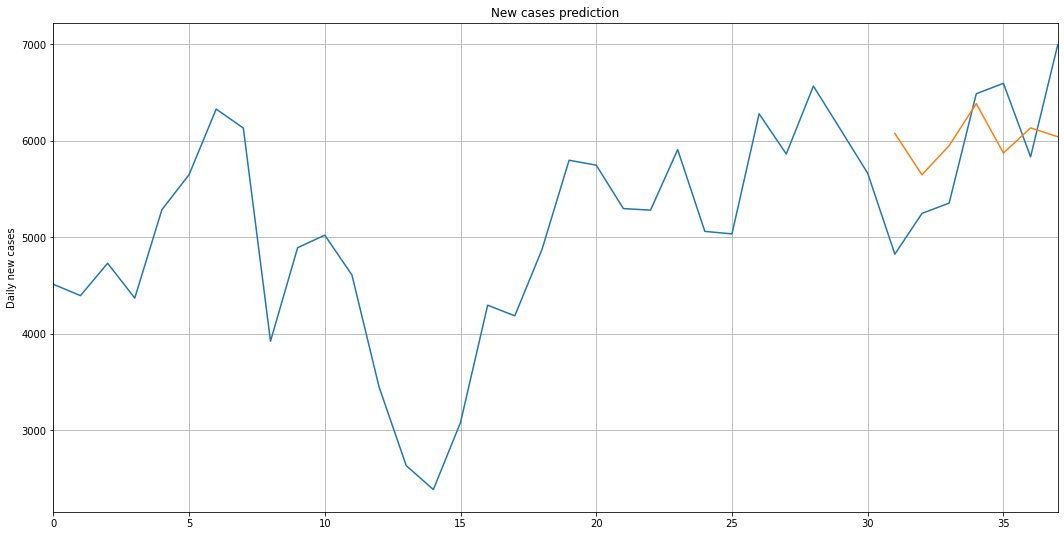

In [ ]:
#plotting prediction
model = 'glove'
dataset = '1'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  617.6818656751087
MAPE :  10.322189267550785
MSE :  515546.3056478162
RMSE :  718.0155330129121


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  591.2808724812099
MAPE :  9.936092080155188
MSE :  520641.13104796084
RMSE :  721.5546625502193


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  589.8503673246929
MAPE :  9.731597054493129
MSE :  494543.7651191919
RMSE :  703.2380572176053


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  577.3540820223944
MAPE :  9.740597932832195
MSE :  451793.06867507804
RMSE :  672.1555390496146


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  590.2592418704714
MAPE :  9.930267739035102
MSE :  502680.2936920683
RMSE :  708.9995018983217


Glove Topic 2

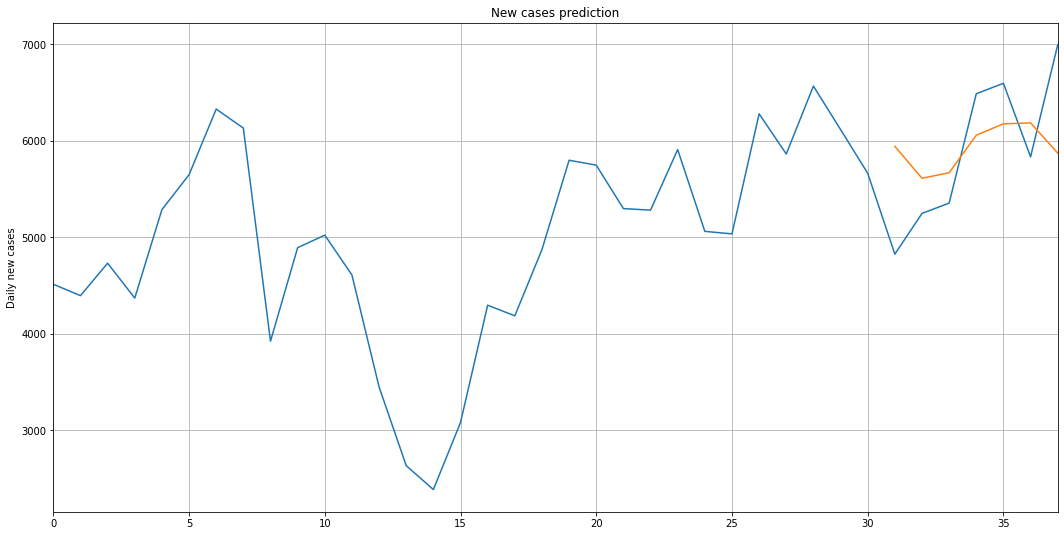

In [ ]:
#plotting prediction
model = 'glove'
dataset = '2'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  588.3456473520824
MAPE :  9.932302812680385
MSE :  460281.2782469526
RMSE :  678.4403276979875


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  605.3943186317172
MAPE :  10.338065518585326
MSE :  517702.3967840939
RMSE :  719.5153902343534


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  627.6946909768241
MAPE :  10.626044724925054
MSE :  492236.18356786814
RMSE :  701.595455777664


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  579.8826969351087
MAPE :  9.672665141550706
MSE :  475429.77507788414
RMSE :  689.514158721838


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  597.6996573380062
MAPE :  10.282406855821767
MSE :  564856.0817941934
RMSE :  751.5690798550679


Glove Topic 3

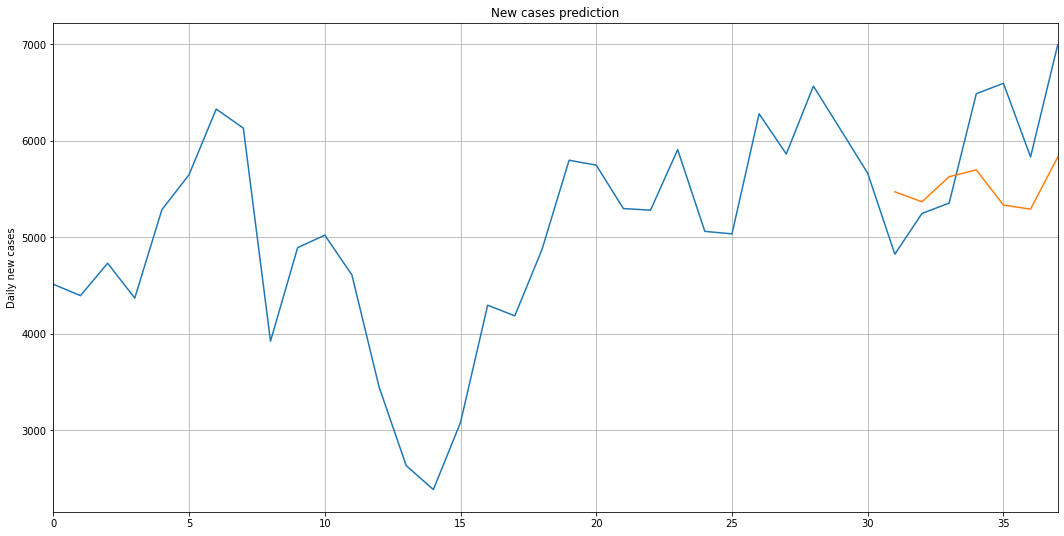

In [ ]:
#plotting prediction
model = 'glove'
dataset = '3'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  628.9092031206403
MAPE :  10.73744553841407
MSE :  604410.2361567164
RMSE :  777.438252311215


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  547.6821731499264
MAPE :  9.30282275175356
MSE :  399098.06054212066
RMSE :  631.7420838776856


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  1432.9224589786359
MAPE :  34.93247048878626
MSE :  3275140.2534450036
RMSE :  1809.7348572221854


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  625.6362884214947
MAPE :  10.45220063813439
MSE :  508755.872386088
RMSE :  713.2712474129936


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  534.6170784575598
MAPE :  9.235915812123679
MSE :  480060.16652010643
RMSE :  692.8637431126747


FastText Topic 0

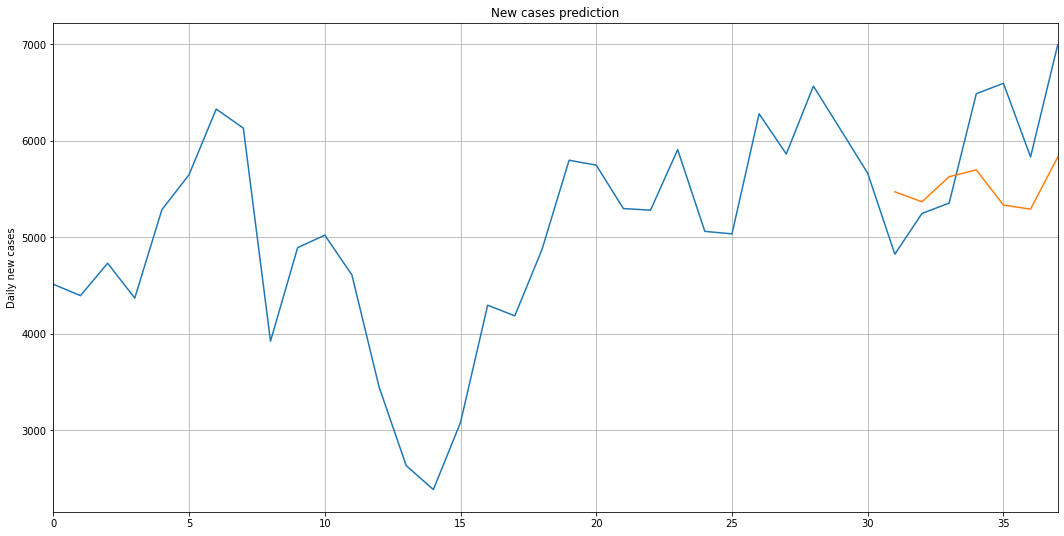

In [ ]:
#plotting prediction
model = 'fasttext'
dataset = '0'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  685.0704696519034
MAPE :  12.373866397382212
MSE :  624046.3233338104
RMSE :  789.9660266959652


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  1315.9430843208518
MAPE :  31.440990076430726
MSE :  2947011.504801039
RMSE :  1716.6861986982476


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  626.2677822964532
MAPE :  10.43006994123671
MSE :  535515.3558309514
RMSE :  731.7891471120294


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  550.6430766241891
MAPE :  9.406666554750318
MSE :  416177.1555325844
RMSE :  645.1179392425732


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  579.1146822316306
MAPE :  9.565998595449784
MSE :  430230.5525833507
RMSE :  655.9196235693446


FastText Topic 1

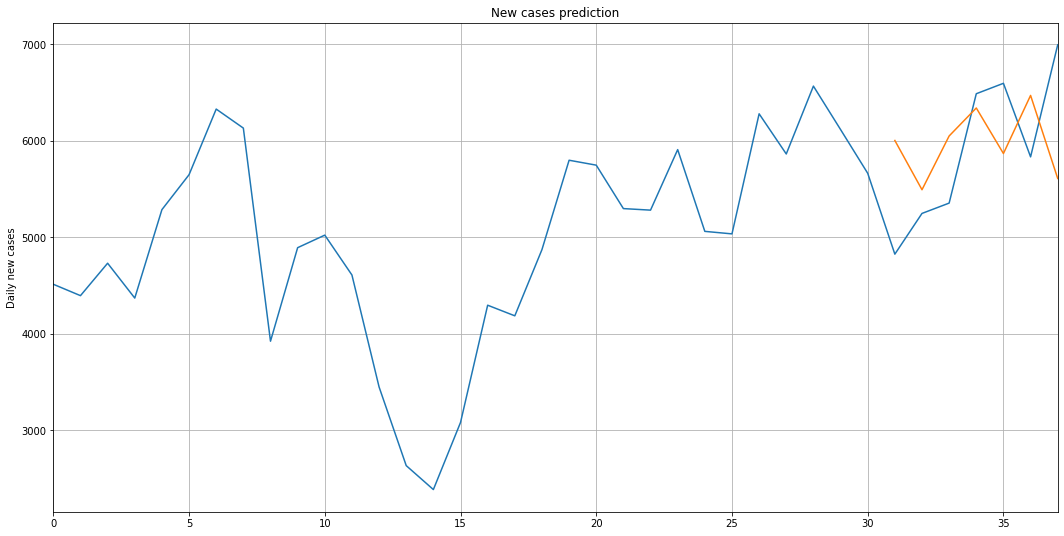

In [ ]:
#plotting prediction
model = 'fasttext'
dataset = '1'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  716.4626582860947
MAPE :  12.122474806833917
MSE :  686465.3908514354
RMSE :  828.5320698991894


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  565.4158454963139
MAPE :  9.453808066790618
MSE :  427479.60694037715
RMSE :  653.8192463826506


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  589.8626556311335
MAPE :  10.637689692290305
MSE :  563406.5554090926
RMSE :  750.604126959806


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  641.9138720887048
MAPE :  10.76671201871422
MSE :  546285.8119632137
RMSE :  739.1115017121664


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  595.6039449572563
MAPE :  10.019771827524357
MSE :  454258.03312439594
RMSE :  673.9866713254766


FastText Topic 2


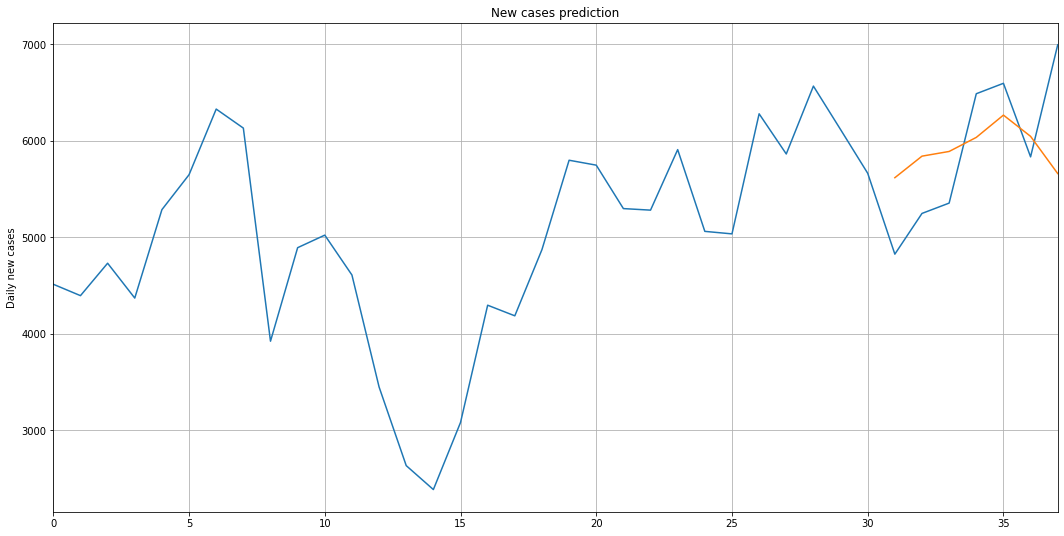

In [ ]:
#plotting prediction
model = 'fasttext'
dataset = '2'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  606.9850417375565
MAPE :  10.457092321919063
MSE :  486284.0563066466
RMSE :  697.340703176465


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  644.6232968398502
MAPE :  10.739666218680156
MSE :  548200.0416190767
RMSE :  740.4053225221147


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  574.8402721626418
MAPE :  9.776718949143834
MSE :  483980.23032126005
RMSE :  695.686876634352


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  620.9517728090286
MAPE :  10.510524401417994
MSE :  534432.7853963467
RMSE :  731.0490991693696


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  505.0731779677527
MAPE :  8.577111373244025
MSE :  460286.6997533728
RMSE :  678.4443232523748


FastText Topic 3


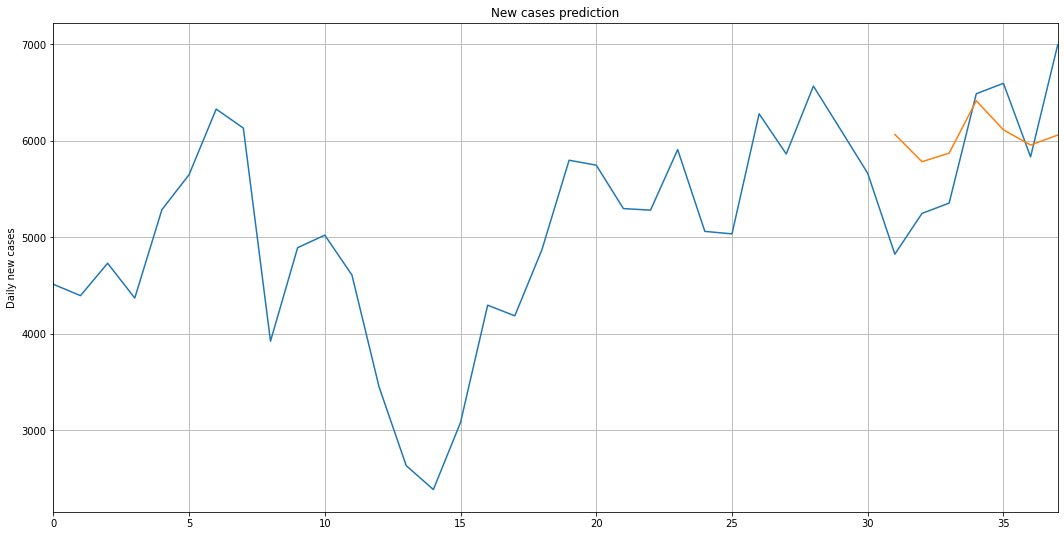

In [ ]:
#plotting prediction
model = 'fasttext'
dataset = '3'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  558.0937410933631
MAPE :  9.294564436777256
MSE :  460062.244727556
RMSE :  678.2788841822779


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  612.7799792630332
MAPE :  10.306096354366693
MSE :  531821.9485414274
RMSE :  729.2612347721682


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  536.5686145680291
MAPE :  9.028315054565438
MSE :  386338.35085695336
RMSE :  621.5612205221247


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  612.2334048577717
MAPE :  10.8639684117141
MSE :  556812.8913038328
RMSE :  746.1989622773759


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  537.9105403423309
MAPE :  9.179521011090445
MSE :  434621.7508204551
RMSE :  659.2584855885095


Bert Topic 0

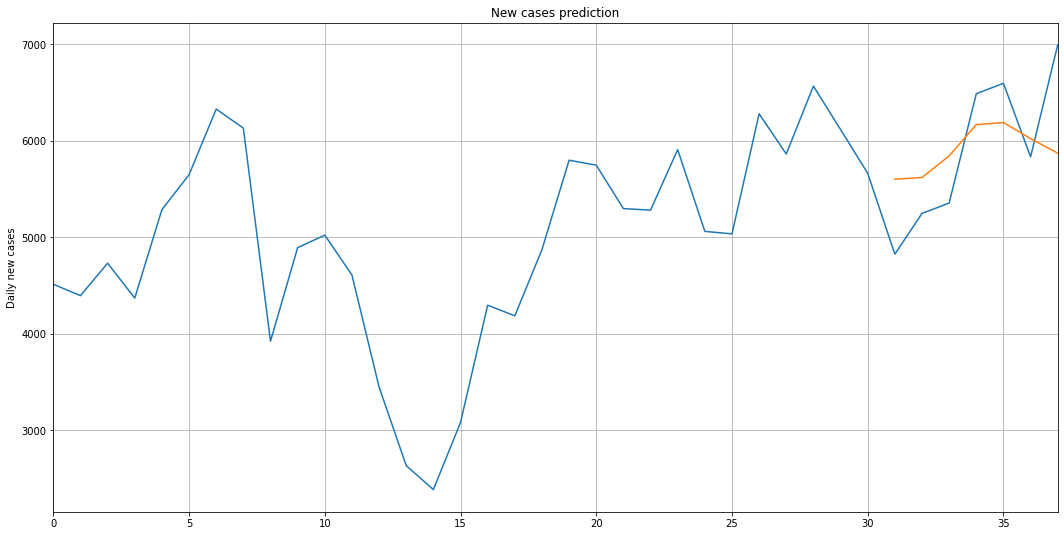

In [ ]:
#plotting prediction
model = 'bert'
dataset = '0'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  524.9929765122278
MAPE :  8.981143523504018
MSE :  363350.69245038554
RMSE :  602.7857765826808


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  560.3302070243018
MAPE :  9.567427836082357
MSE :  493220.7810057408
RMSE :  702.2967898301549


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  553.7636065653393
MAPE :  9.524395323463123
MSE :  480964.98606594786
RMSE :  693.51639206723


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  554.6403977530343
MAPE :  9.435152893847047
MSE :  399243.39175097615
RMSE :  631.8570975711012


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  526.4477838618415
MAPE :  8.977212070134831
MSE :  431094.43352620053
RMSE :  656.5778198554993


Bert Topic 1

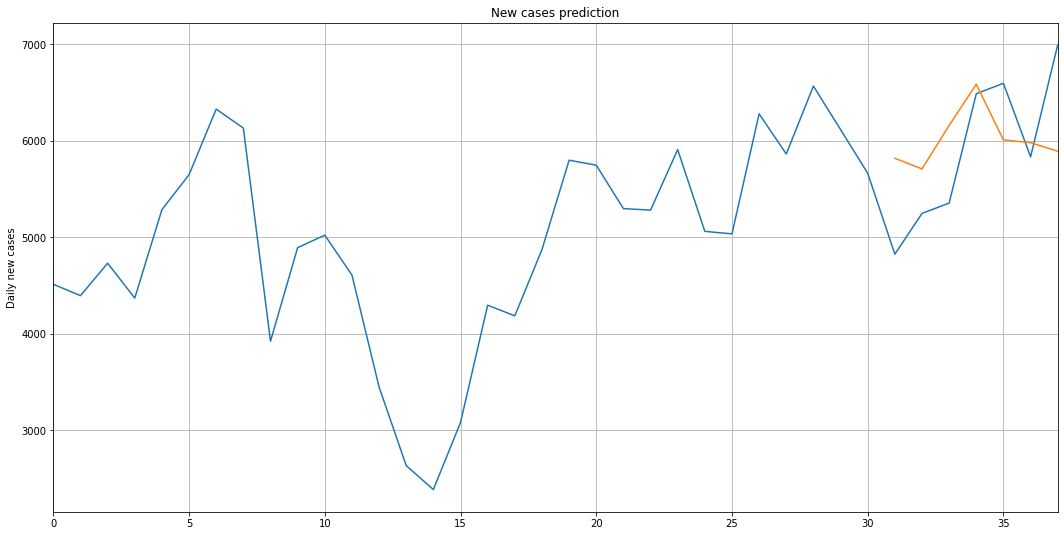

In [ ]:
#plotting prediction
model = 'bert'
dataset = '1'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  598.9057680198124
MAPE :  10.091395871604002
MSE :  490922.0685588921
RMSE :  700.6583108469436


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  591.4632542303631
MAPE :  10.0071554992696
MSE :  481232.05350438546
RMSE :  693.708911218809


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  591.3738028321948
MAPE :  9.4113079514497
MSE :  542755.2887950222
RMSE :  736.7192740759687


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  626.8101183516638
MAPE :  10.3978500889194
MSE :  522814.7756691345
RMSE :  723.0593168400048


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  645.2848796844482
MAPE :  10.46486389283833
MSE :  563154.6617914891
RMSE :  750.4363142808916


Bert Topic 2

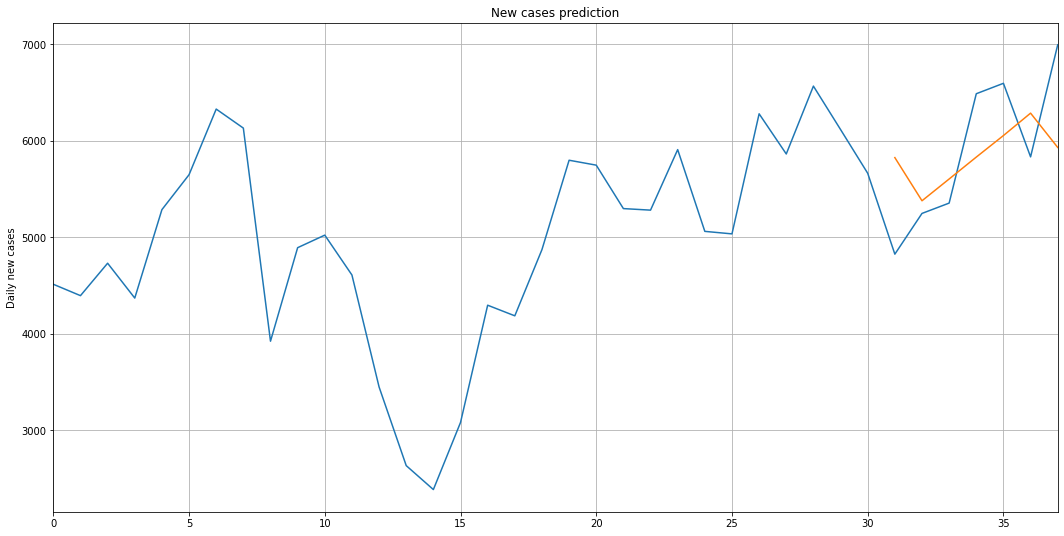

In [ ]:
#plotting prediction
model = 'bert'
dataset = '2'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  585.0047228847232
MAPE :  9.915905885653485
MSE :  448583.88873317634
RMSE :  669.7640545245589


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  542.8039379460471
MAPE :  9.215976612556162
MSE :  439747.44676176633
RMSE :  663.1345615799002


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  563.555220076016
MAPE :  9.674353504727996
MSE :  484017.3871563529
RMSE :  695.7135812648427


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  628.9403034789221
MAPE :  10.41781948102436
MSE :  503955.89368460927
RMSE :  709.898509425544


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  540.5574721608843
MAPE :  9.319946154720295
MSE :  456692.8062123268
RMSE :  675.7905046775419


Bert Topic 3

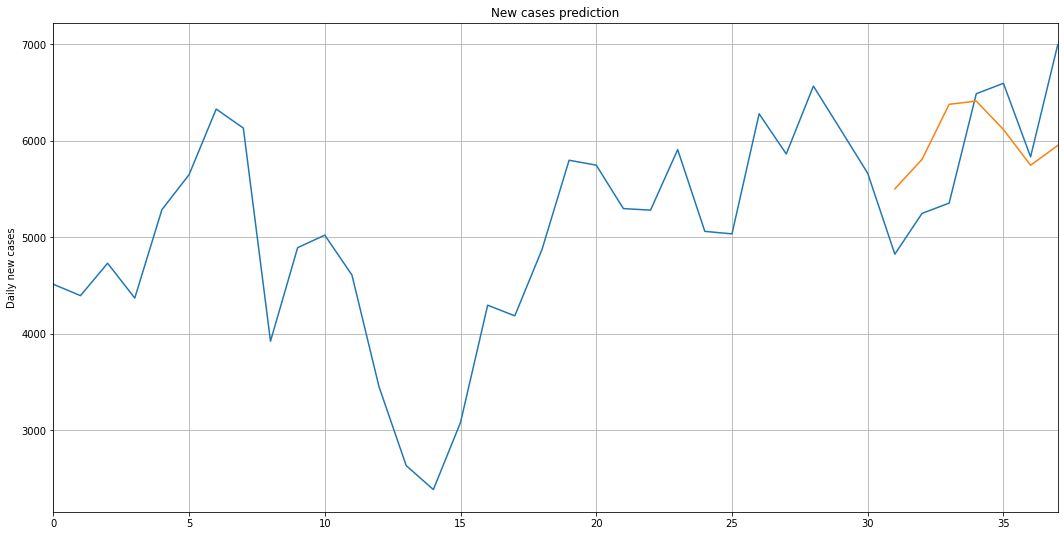

In [ ]:
#plotting prediction
model = 'bert'
dataset = '3'

plotting(actual_predictions, model, dataset)

In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  563.5126826337406
MAPE :  9.436219898497697
MSE :  449918.54455741175
RMSE :  670.7596771999729


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  553.2754970278058
MAPE :  9.291557024430379
MSE :  448287.3101052052
RMSE :  669.5426126134207


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  575.3185832330158
MAPE :  9.755209819359342
MSE :  437716.21189878666
RMSE :  661.6012484108435


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  595.8521995033536
MAPE :  10.054357798401261
MSE :  514024.739234276
RMSE :  716.9551863500786


In [ ]:
cov = new_cases

print('MAE : ', mae( cov[-7:], actual_predictions.reshape(7,)))
print('MAPE : ', mape (cov[-7:], actual_predictions.reshape(7,)))
print('MSE : ', mse( cov[-7:], actual_predictions.reshape(7,)))
print('RMSE : ', rmse( cov[-7:], actual_predictions.reshape(7,)))

MAE :  553.6598958969116
MAPE :  9.346811586291249
MSE :  427693.4134697414
RMSE :  653.9827317825307


########################################

Combine tweets based on date

In [ ]:
tw = pd.read_csv("drive/My Drive/Thesis/Data/Cluster/task1_may_june/bert_cluster_3.csv")
tw = tw[['date','clean_sentences']]
tw['date'] = pd.to_datetime(tw['date']).dt.date
tw1 = tw.groupby(['date'], as_index = False).agg({'clean_sentences': ','.join})
tw1

,date,clean_sentences
0,2021-05-01,merinding lihat laut manusia tanah abang kmare...
1,2021-05-02,jaga malam penuh suspek covid mari istirahat b...
2,2021-05-03,malaysia darurat covid medan nang jalur sibuk ...
3,2021-05-04,kkata gubernur jatim pandemi covid iniih dampa...
4,2021-05-05,covid seringkali peluru sasar sipil sebenernya...
5,2021-05-06,mudik dibangap bajing sempit blokade ancam bur...
6,2021-05-07,"nyium kena covid nyata iya kali cium,danton is..."
7,2021-05-08,rm pkp rakyat prihatin patuh sop rana gak dar ...
8,2021-05-09,corona ganas paska lebaran perintah mengantisp...
9,2021-05-10,sorang imam masjid jb tinggal covid innalillah...


In [ ]:
combined_tweets = tw1.to_csv("drive/My Drive/Thesis/Data/Tweet_TM/task1_may_june/bert_cluster_3_combined.csv", index=False)

In [ ]:
t = pd.read_csv("drive/My Drive/Thesis/Data/Tweet_TM/task1_may_june/lda_cluster_0_combined.csv")
t

,date,clean_sentences
0,2021-05-01,merinding lihat laut manusia tanah abang kmare...
1,2021-05-02,jaga malam penuh suspek covid mari istirahat b...
2,2021-05-03,malaysia darurat covid medan nang jalur sibuk ...
3,2021-05-04,sabtu kemarin lippo mall kemang akuin hindar k...
4,2021-05-05,covid seringkali peluru sasar sipil sebenernya...
5,2021-05-06,mudik dibangap bajing sempit blokade ancam bur...
6,2021-05-07,"nyium kena covid nyata iya kali cium,danton is..."
7,2021-05-08,"serius kopit jaga pasien covid,inget kick it b..."
8,2021-05-09,corona ganas paska lebaran perintah mengantisp...
9,2021-05-10,"nyenyak tidur mimpi positif corona,korang tena..."
